Pump Data Analysis
---

This report aims to make a quit analysis of the Pump 10 data set.

In [1]:
# Author: Thiago Akio Nakamura
# E-mail: akionakas@gmail.com

# Import necessary classes and libraries
%matplotlib inline
import numpy as np
import pandas as pd
import numpy.ma as ma
from StringIO import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

from matplotlib.colors import LogNorm
from matplotlib.colors import Colormap 
from scipy import linalg
from scipy.stats import randint
from operator import itemgetter

from time import time

from sklearn.mixture import MPPCA
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_blobs

We start loading the data, expected to be in a .csv format. The type of data on each column also has to be previously known.

In [2]:
# The data should be on subdirectory called "data"
load_start = time()
orig_data = np.genfromtxt("./data/bomba10.csv",
              dtype="|S32, float, float, float, float, float, float, float, float, float, float, |S32, float, float, float, |S32, |S32, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, |S32, float, float, |S32, |S32",
              skip_header=2,
              autostrip=True,
              delimiter=",",
              names=True)
names = orig_data.dtype.names
load_end = time()

print 'Took {} seconds to load the data.'.format(load_end-load_start)
print 'Loaded {} values from {} columns.'.format(orig_data.shape[0], len(names))

Took 21.6370720863 seconds to load the data.
Loaded 217441 values from 43 columns.


From another .csv file, the information for each variable is obtained. The information includes the variables description, engineering units and their zero/span.

In [3]:
# Load units info
units = np.genfromtxt("/Users/AkioNakamura/Dropbox/PFC/Codes/fdd/data/bomba10_description.csv",
              dtype="|S8",
              skip_footer=5,
              autostrip=True,
              delimiter=",",
              usecols=(3))
units[0] = 'Time'

# Load zero/span info
zero_span = np.genfromtxt("/Users/AkioNakamura/Dropbox/PFC/Codes/fdd/data/bomba10_description.csv",
              dtype="float, float",
              skip_footer=5,
              autostrip=True,
              delimiter=",",
              usecols=(4,5))
zero_span[0] = (0.0, 0.0)

# Load the data descriptions
descriptions = np.genfromtxt("/Users/AkioNakamura/Dropbox/PFC/Codes/fdd/data/bomba10_description.csv",
              dtype="|S128",
              skip_footer=5,
              autostrip=True,
              delimiter=",",
              usecols=(2))
descriptions[0] = 'Time'
for idx, s in enumerate(descriptions):
    descriptions[idx] = s.replace('P-57: ', '') \
        .replace('A-T', '') \
        .replace('P-T', '') \
        .replace('PM-T', '') \
        .replace('2610 - ', '') \
        .replace('2611 - ', '') \
        .replace('S-T4101 - ', '') \
        .replace('T26 - ', '') \
        .replace('2613 - ', '') \
        .replace('2611 -', '') \

print 'Following are the variables in the data:'
descriptions

Following are the variables in the data:


array(['Time', 'Vazao agua de injecao', 'Vazao agua de injecao',
       'Rotacao bomba de injecao', 'DP filtro oleo lubrificante',
       'Potcncia hidraulica da bomba de injecao de agua 2611',
       'Pressao oleo lubrificante', 'Pressao descarga',
       'Pressao oleo lubrificante', 'Pressao descarga agua de injecao',
       'Pressao succao agua de injecao',
       'PRESSURE SUCTION (WATER INJECTION PUMP A - 2610) :BYPASS',
       'Head - BOMBA 2610', 'Horimetro Parcial - BOMBA 2610',
       'Numero de partidas da bomba BOMBA 2610',
       'Status da bomba de injecao A',
       'WATER INJECTION PUMP A TRIPPED :BYPASS',
       'Temperatura do Mancal Axial do Lado Ativo',
       'Temperatura do Mancal Axial do Lado Inativo',
       'Temperatura do Mancal Radial do Lado Nao Acoplado',
       'Temperatura do Mancal Radial do Lado Acoplado',
       'Temperatura do Mancal Radial do Lado Acoplado',
       'Temperatura do Mancal Radial do Lado Nao Acoplado',
       'Temperatura do Enrolament

Now we separate the real numerical data from the categorical data and capture the indexes of each state of the 'WATER INJECTION PUMP A TRIPPED' variable.

In [4]:
# Transfer data for a Pandas' DataFrame, similar to R's data frame.
complete_data_frame = pd.DataFrame(data=orig_data,
                          index=orig_data['1m'],
                          columns=names)
# Get numerical data
data_frame = complete_data_frame.select_dtypes(include=['float64'])
data_idxs = complete_data_frame.dtypes == 'float64'
data_names = complete_data_frame.axes[1][data_idxs]
data_descriptions = descriptions[data_idxs.values]
data_units = units[data_idxs.values]
data_zero_span = zero_span[data_idxs.values]

# Get categorical data
categorical_data = complete_data_frame.select_dtypes(include=['object'])
categorical_idxs = complete_data_frame.dtypes == 'object'
categorical_names = complete_data_frame.axes[1][categorical_idxs]
categorical_descriptions = descriptions[categorical_idxs.values]
categorical_units = units[categorical_idxs.values]
categorical_zero_span = zero_span[categorical_idxs.values]

# Get idxs of the known categories for the '301072_T26_SXA_109_BYP_1'
normal_idx = categorical_data[u'301072_T26_SXA_109_BYP_1'] == 'Normal'
timeout_idx = categorical_data[u'301072_T26_SXA_109_BYP_1'] == 'I/O Timeout'
shut_idx = categorical_data[u'301072_T26_SXA_109_BYP_1'] == 'Intf Shut'
failed_idx = categorical_data[u'301072_T26_SXA_109_BYP_1'] == 'Failed'

For each categorical data, we check how many samples are on the category.

In [5]:
# Print infos of except the first, each is the time vector
n_categories = len(categorical_names)
for i in (np.arange(n_categories - 1) + 1):
    print 'Categorical Data {}: {} - {}'.format(i, categorical_names[i], categorical_descriptions[i])
    print categorical_data[categorical_names[i]].value_counts()
    print ''

Categorical Data 1: 301072_T26_PSI_106_BYP - PRESSURE SUCTION (WATER INJECTION PUMP A - 2610) :BYPASS
Normal         207926
Bypassado        6516
I/O Timeout      2321
Intf Shut         402
Failed            276
dtype: int64

Categorical Data 2: 301072_T26_PT2611 - Status da bomba de injecao A
OPERANDO       183470
PARADO          31860
I/O Timeout      1350
Intf Shut         491
Failed            270
dtype: int64

Categorical Data 3: 301072_T26_SXA_109_BYP - WATER INJECTION PUMP A TRIPPED :BYPASS
Normal         214442
I/O Timeout      2321
Intf Shut         402
Failed            276
dtype: int64

Categorical Data 4: 301072_T26_YHL_110 - Disjuntor 2611
Fechado        182893
Aberto          31846
I/O Timeout      1412
Intf Shut        1026
Failed            264
dtype: int64

Categorical Data 5: 301072_T26_ZSC_105_BYP - DISCHARGE WI PUMP A CLOSED (WATER INJECTION PUMPS) :BYPASS
Normal         214442
I/O Timeout      2321
Intf Shut         402
Failed            276
dtype: int64

Categoric

Now we plot the time series for each of the numerical values, color coded by each of the known categories.

/Library/Python/2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Library/Python/2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


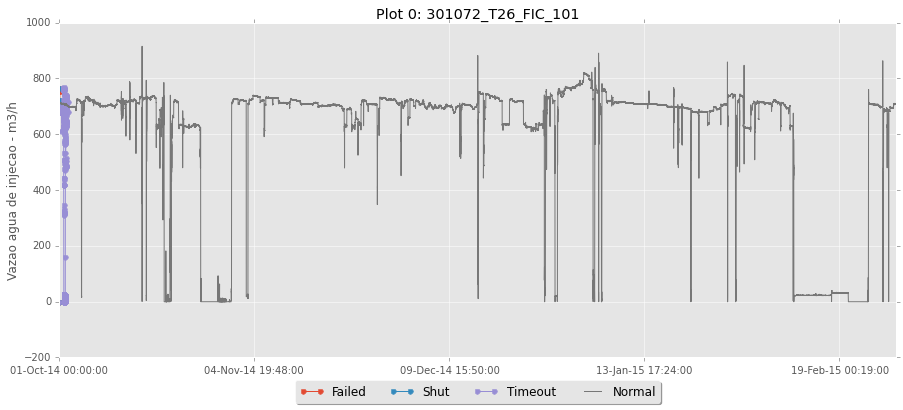

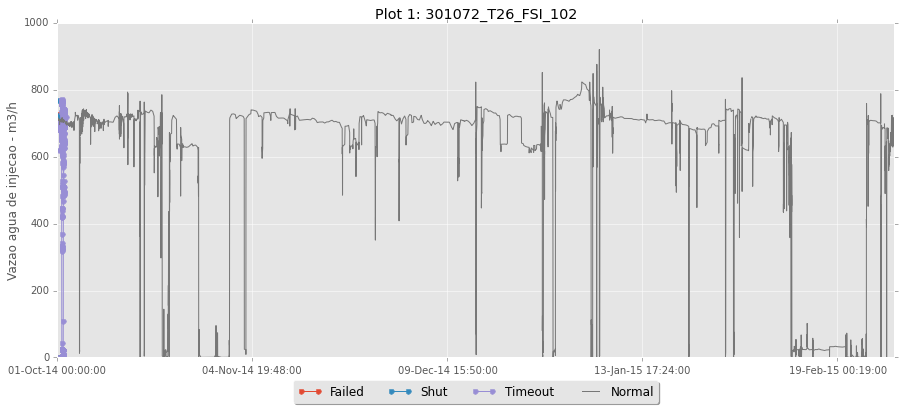

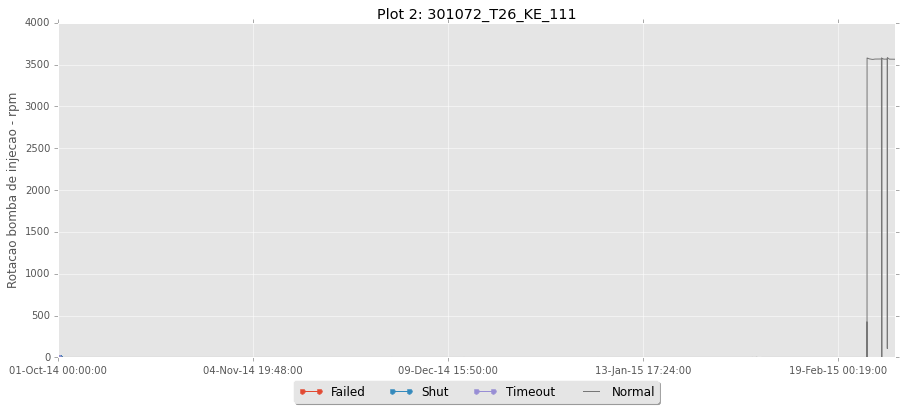

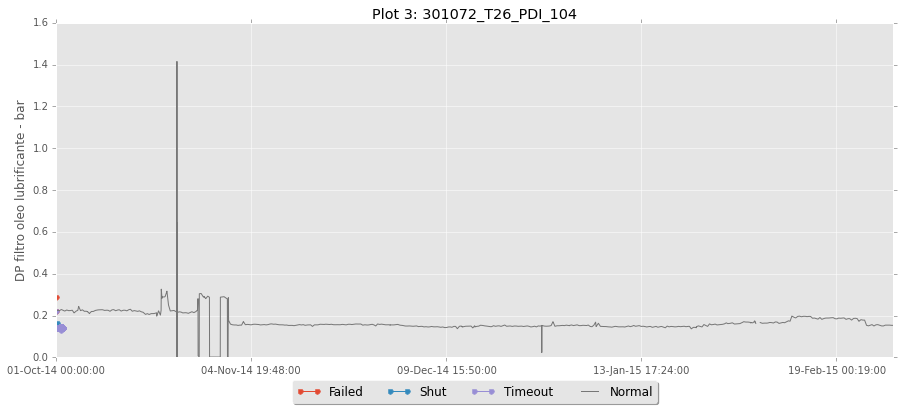

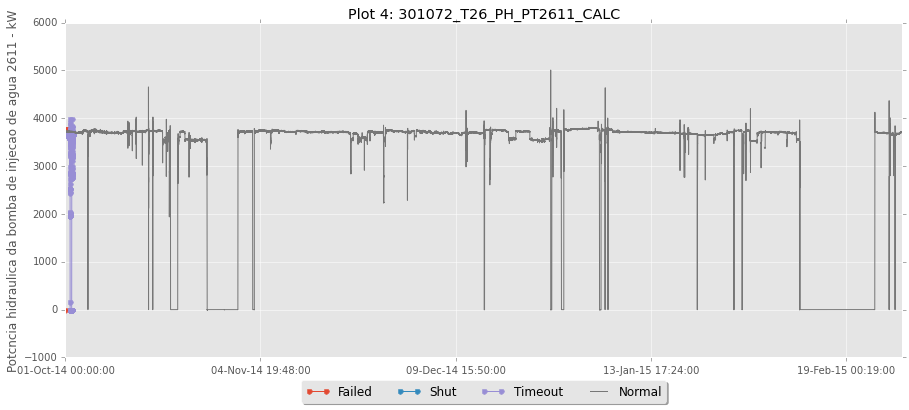

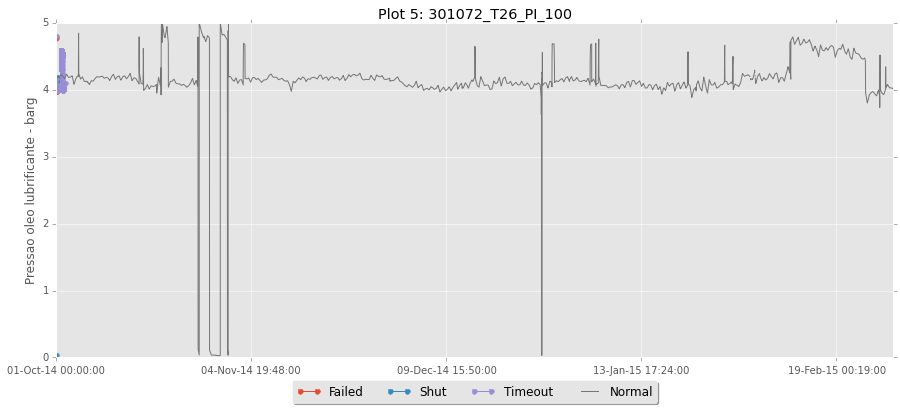

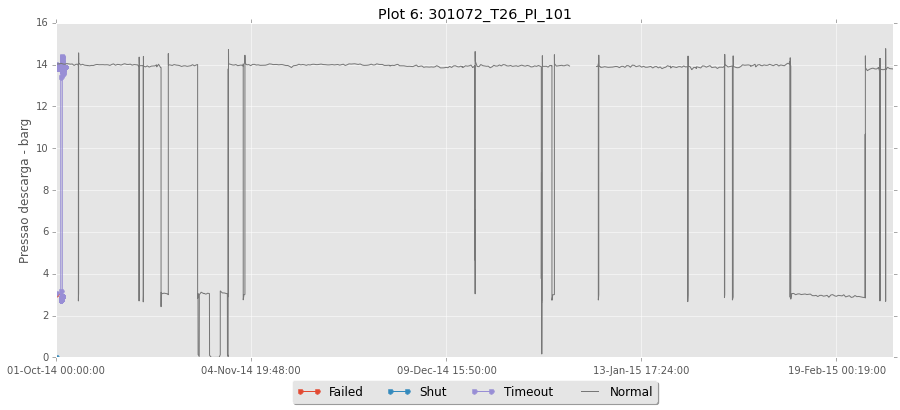

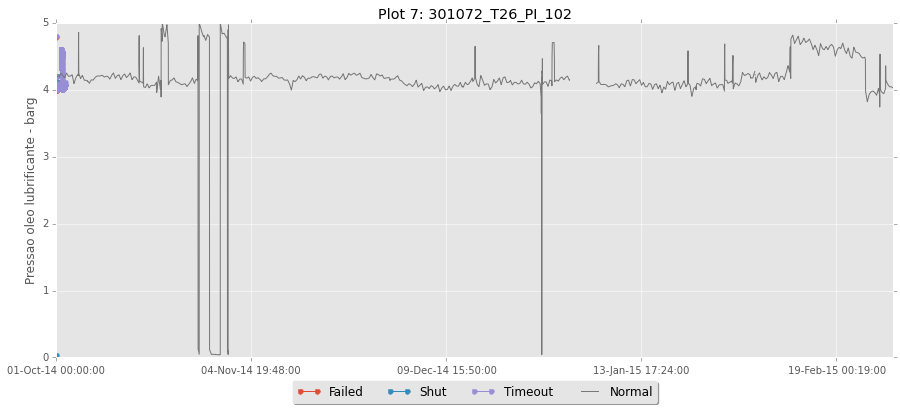

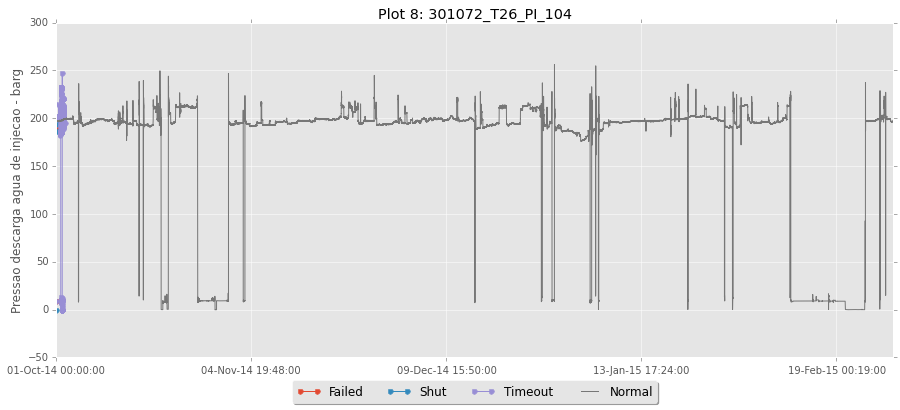

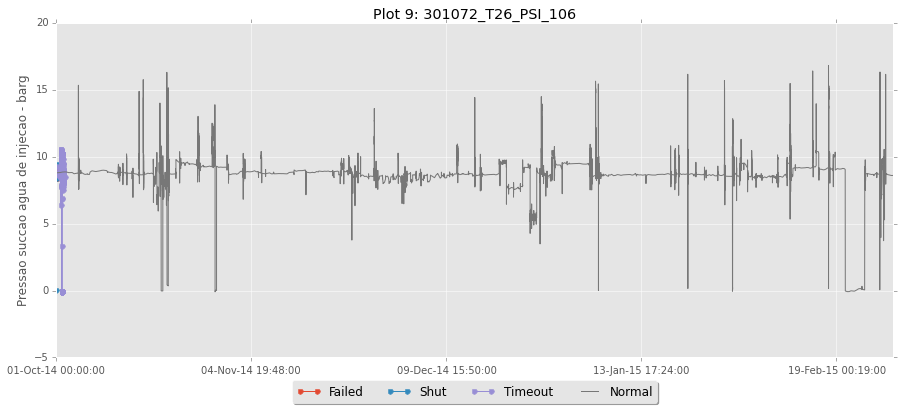

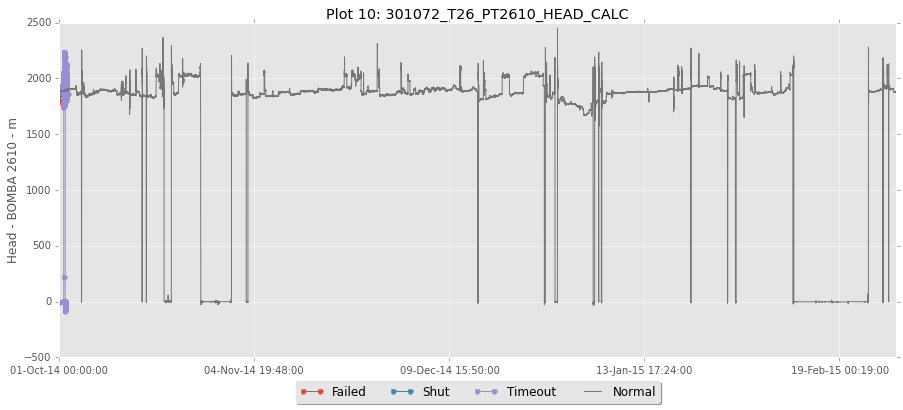

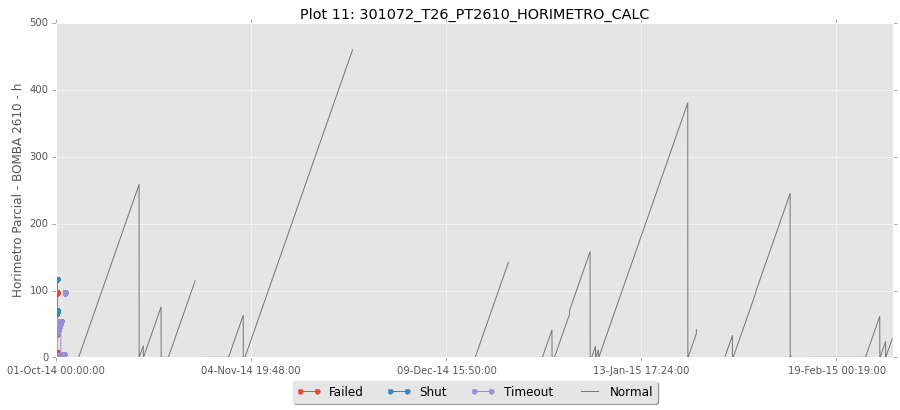

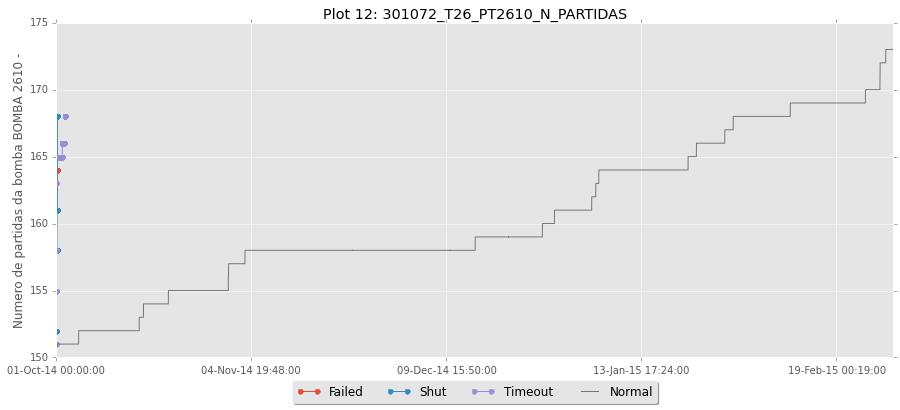

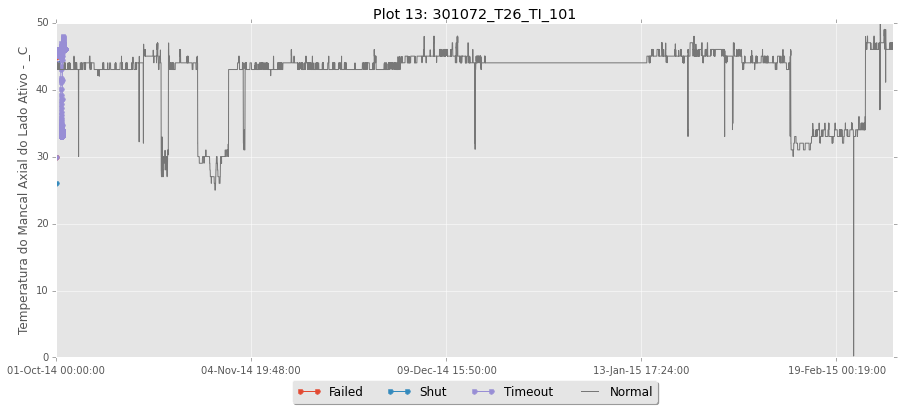

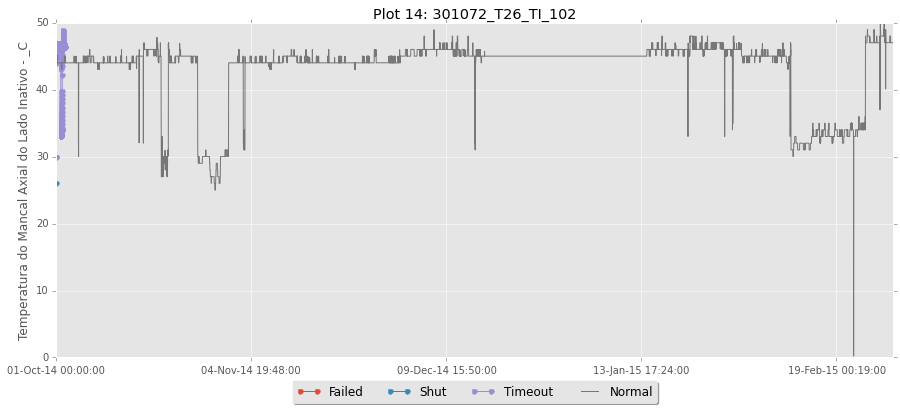

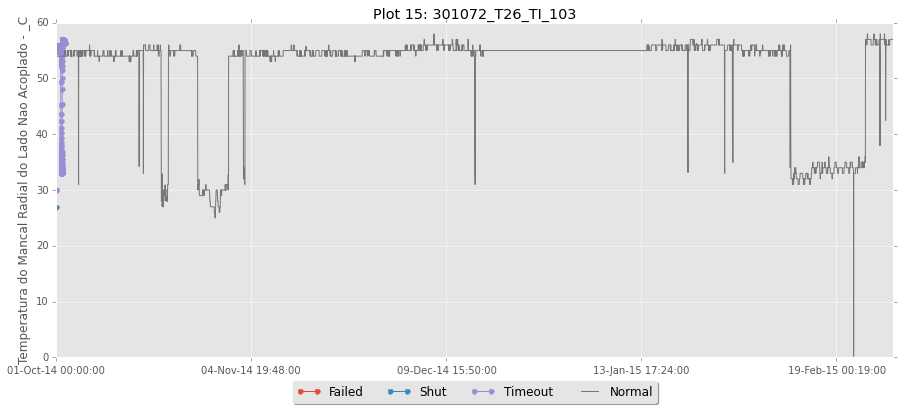

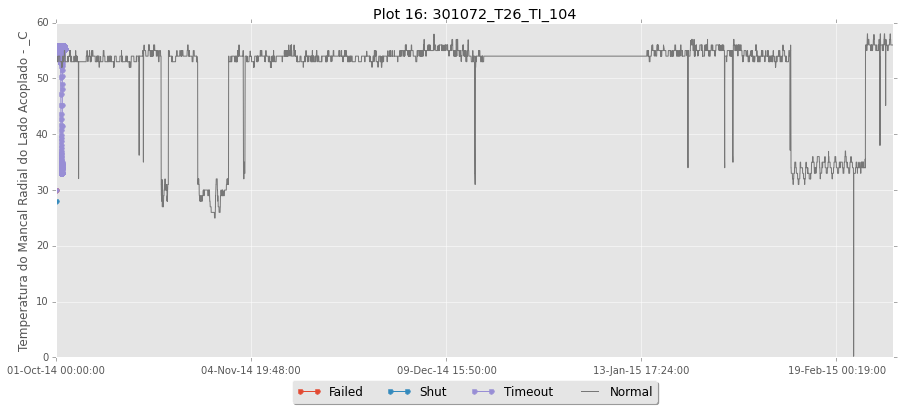

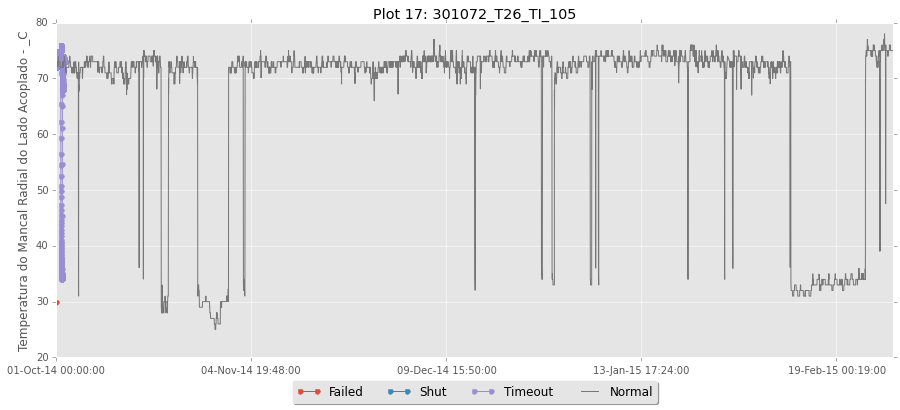

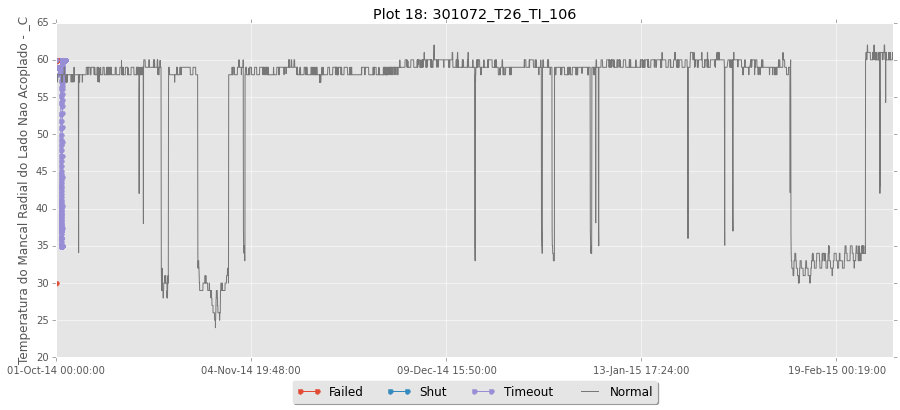

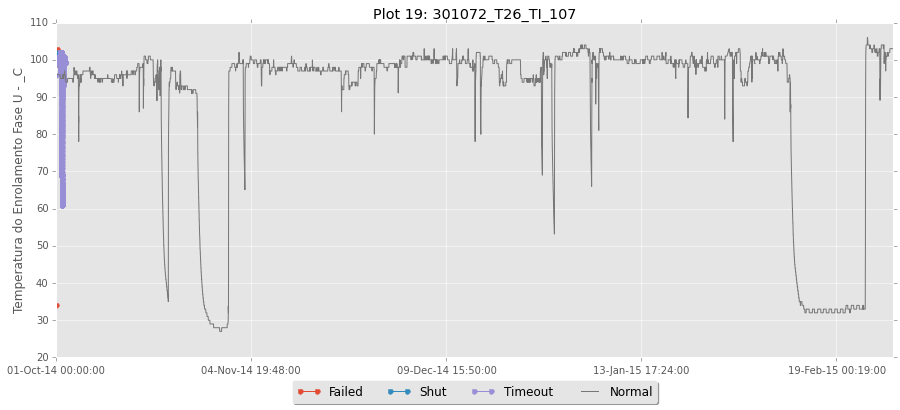

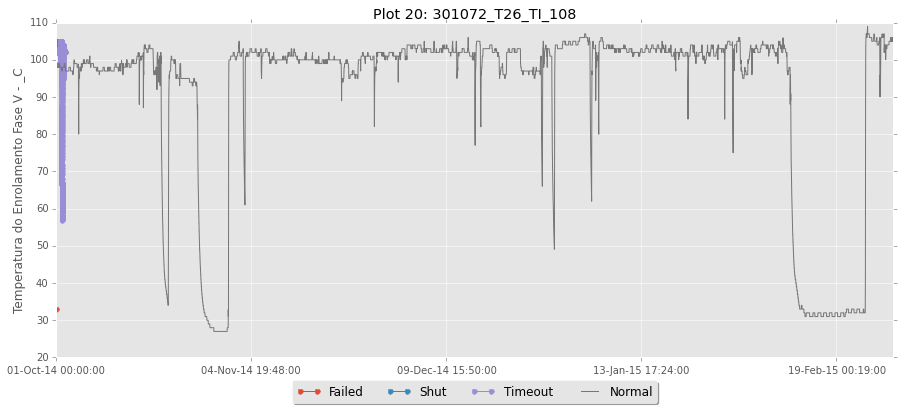

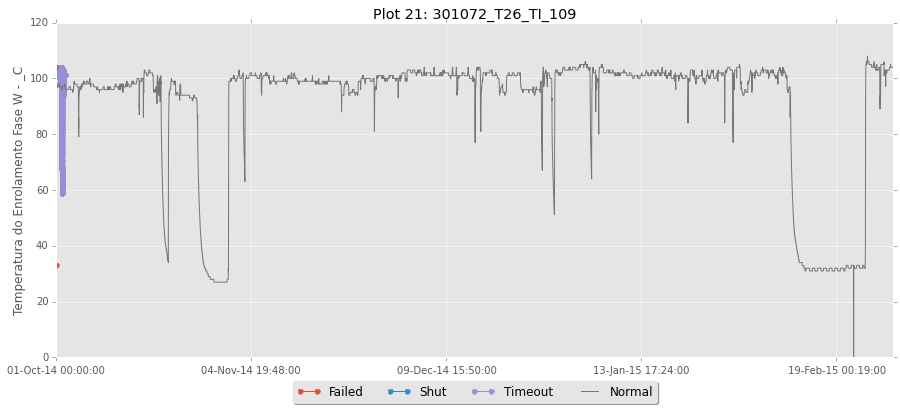

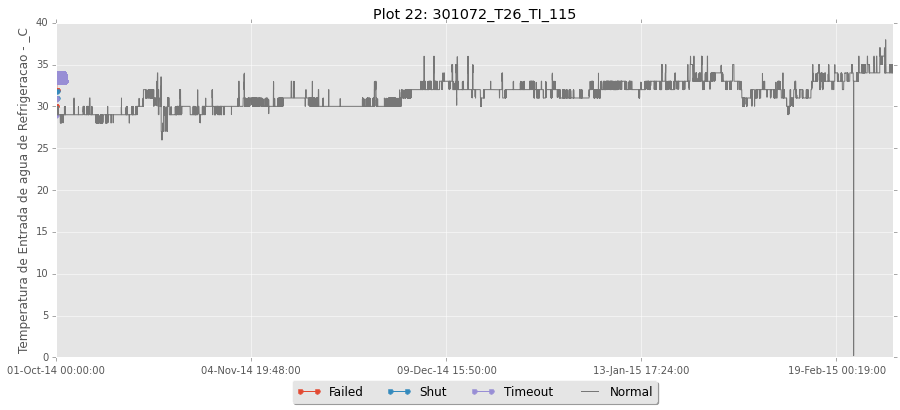

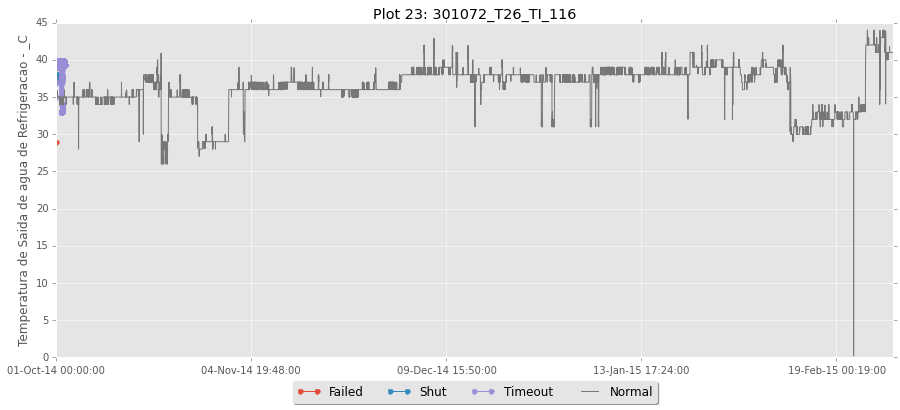

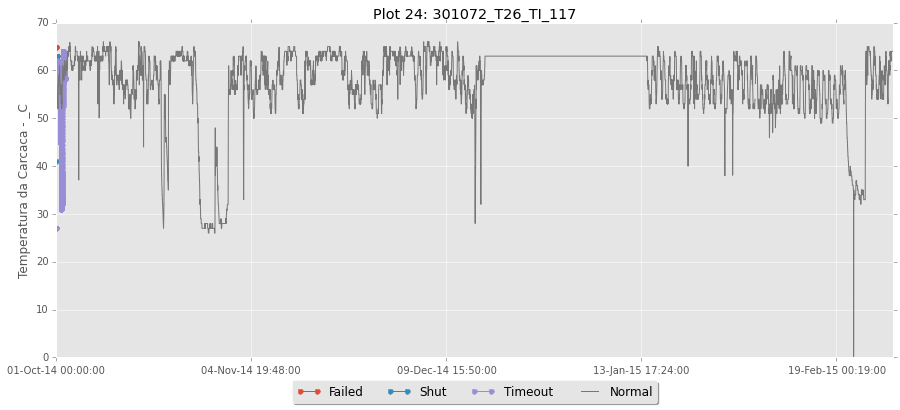

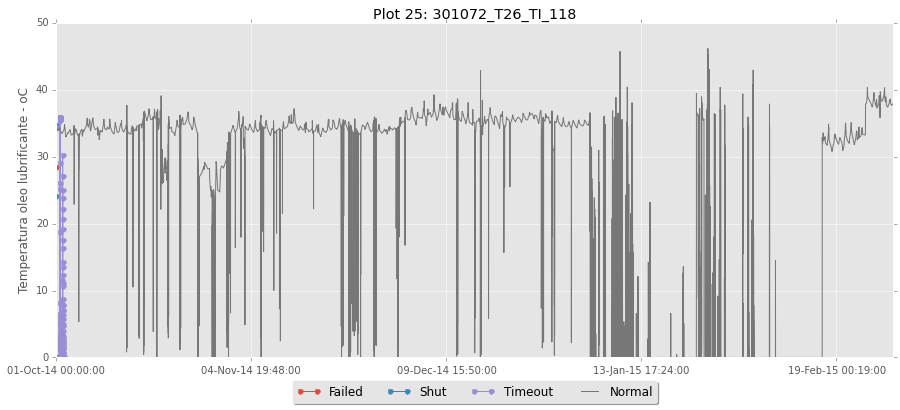

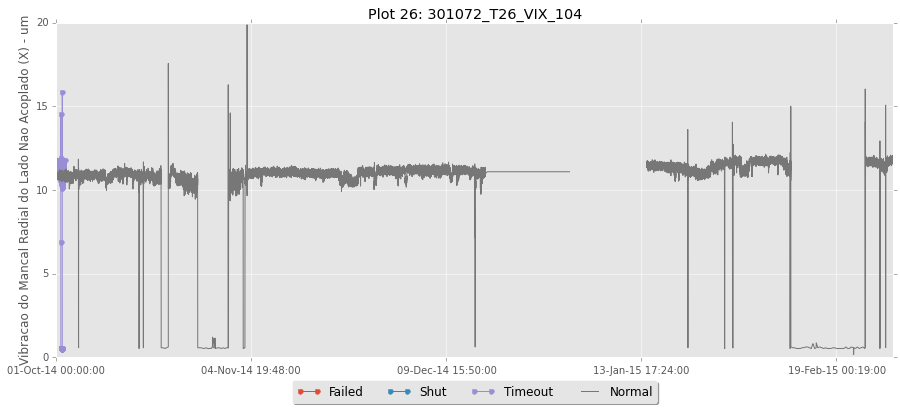

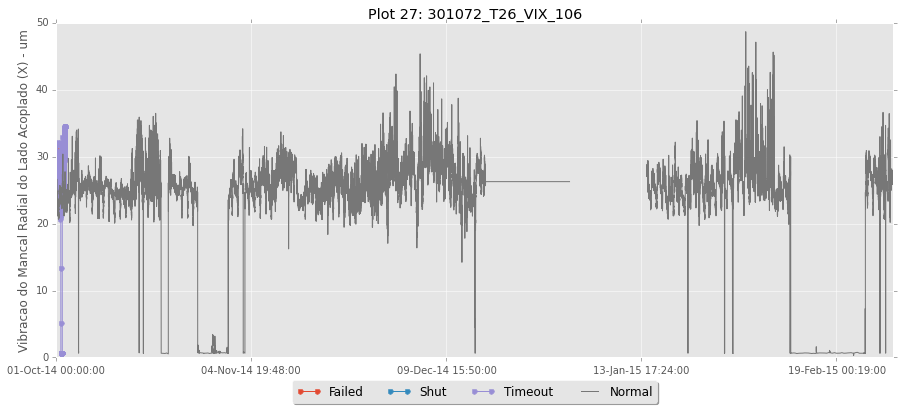

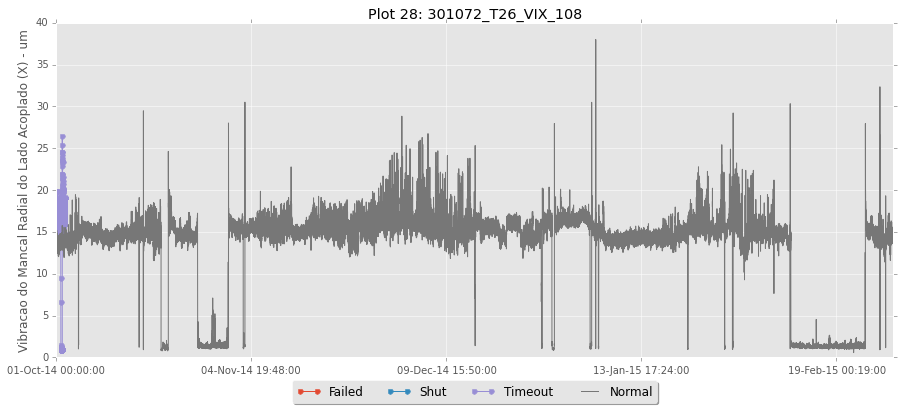

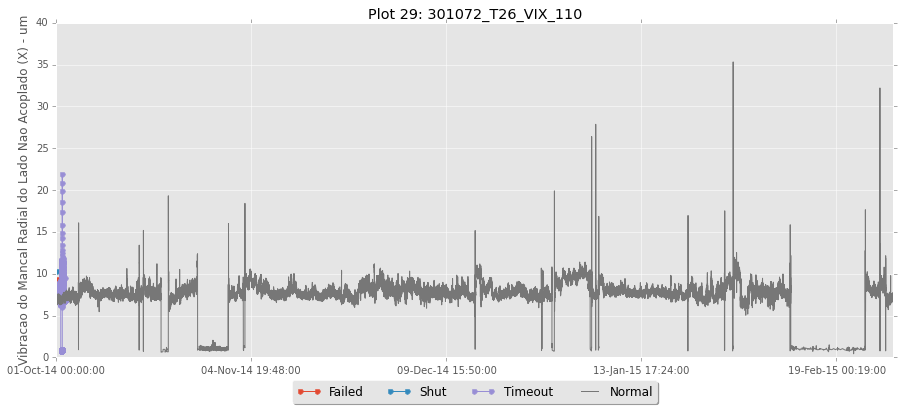

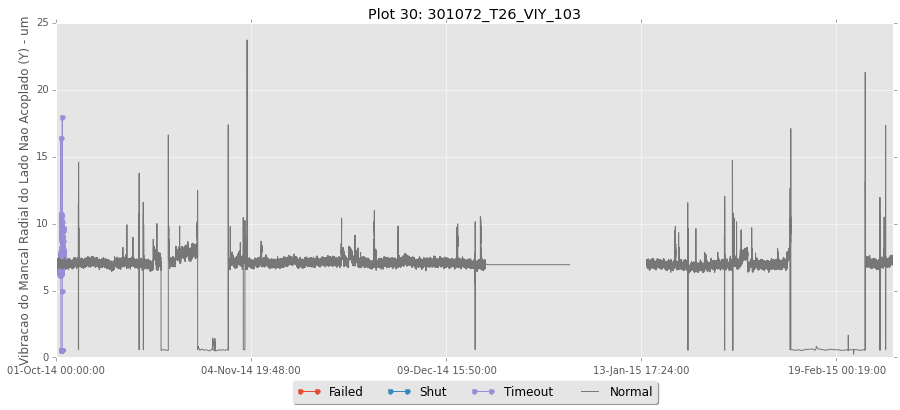

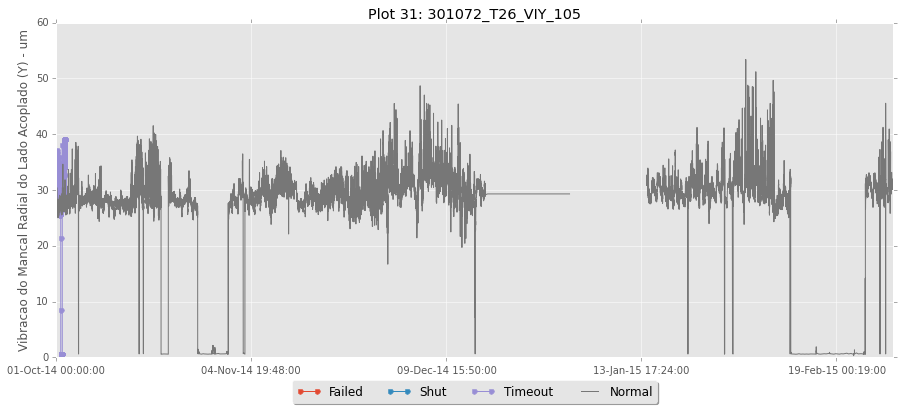

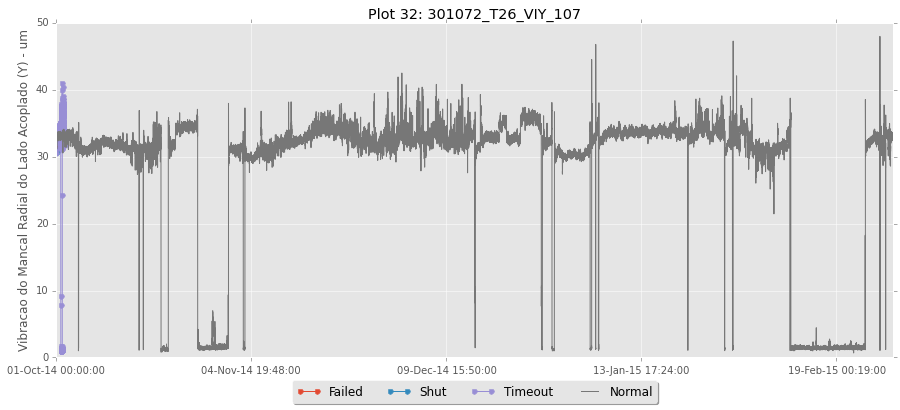

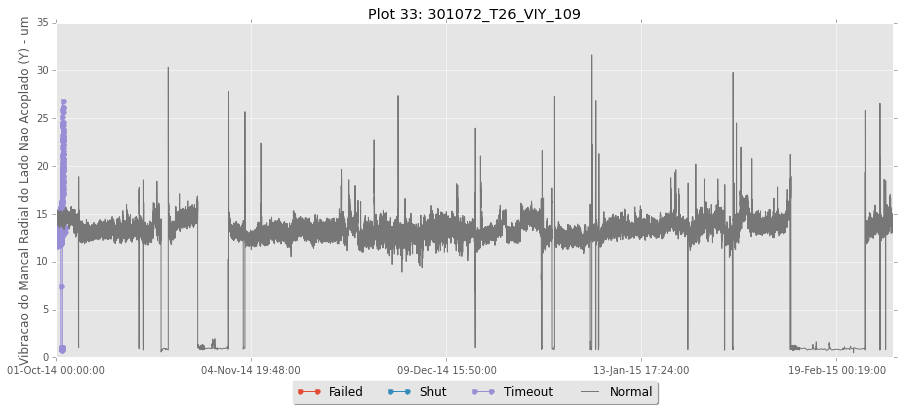

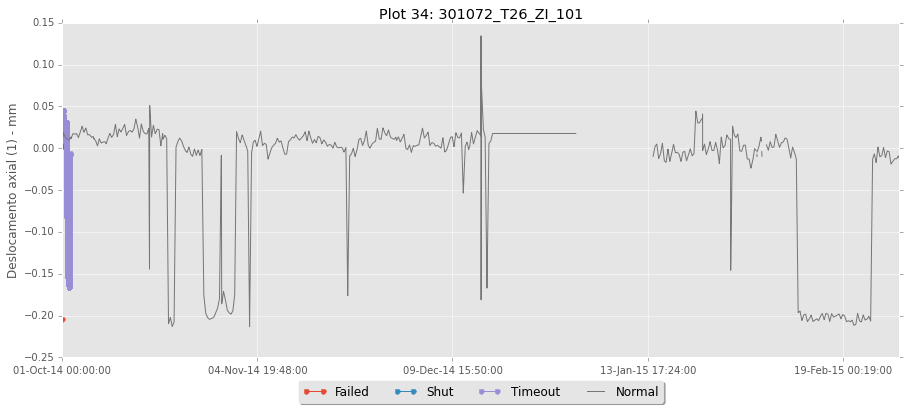

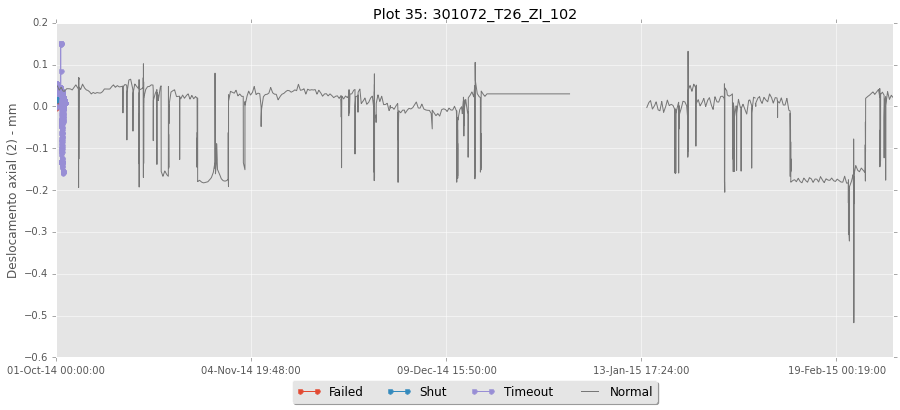

In [6]:
# Plot each numerical data color coded with categorical data
n_features = len(data_names)
for i in np.arange(n_features):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(15, 6))
    ax = plt.subplot(111)
    data_frame[data_names[i]][failed_idx].plot(ax=ax, label='Failed', marker='.', markersize=10)
    data_frame[data_names[i]][shut_idx].plot(ax=ax, label='Shut', marker='.', markersize=10)
    data_frame[data_names[i]][timeout_idx].plot(ax=ax, label='Timeout', marker='.', markersize=10)
    data_frame[data_names[i]][normal_idx].plot(ax=ax, label='Normal')
    plt.title('Plot {}: {}'.format(i, data_names[i]))
    plt.ylabel('{} - {}'.format(data_descriptions[i], data_units[i]))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=4)
    fig.show()